## MIE424 (2023 Winter) Lab 6

Presented by Bo Tang

In this lab, you will explore convex optimization with `cvxpy`. You will gain hands-on experience with `cvxpy` and solve optimization problems in the field of Machine Learning and Data Science.

What will you learn?
- **Cvxpy Foundations:** Grasp the basic knowledge of `cvxpy` to define and solve optimization problems.
- **Lasso and Ridge Regression:** Explore Lasso and Ridge Regression, two essential techniques for regularization in linear regression
- **Non-Negative Least Squares:** Formulate NNLS, which restricts the solution to be non-negative, making it ideal for many applications in signal processing and statistics.
- **Huber Regression:** Learn about Huber Regression, a robust regression technique that is less sensitive to outliers.

### Import Packages

In [1]:
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Cvxpy Foundations

`cvxpy` is a Python-embedded modeling language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

The code below solves a simple optimization problem in `cvxpy`:

#### What is cvxpy?

In [2]:
# create two scalar optimization variables
x = cp.Variable()
y = cp.Variable()

# create two constraints
constraints = [x + y == 1,
               x - y >= 1]

# form objective
obj = cp.Minimize((2*x - y)**2)

# create problem
prob = cp.Problem(obj, constraints)

# solve problem
prob.solve()
# returns the optimal value
print(f"optimal objective value: {prob.value}")
print(f"optimal solution: x = {x.value:.2f}, y = {y.value:.2f}")

optimal objective value: 4.0
optimal solution: x = 1.00, y = 0.00


The status, which was assigned a value optimal by the solve method, tells us the problem was solved successfully. The optimal value is the minimum value of the objective over all choices of variables that satisfy the constraints. The last thing printed gives values of x and y that achieve the optimal objective.

`prob.solve()` returns the optimal value and updates `prob.status`, `prob.value`, and the value field of all the variables in the problem.

#### Changing the problem

Problems are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.

In [3]:
# replace the objective
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print(f"optimal value: {prob2.solve():.2f}")

# replace the constraint (x + y == 1)
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print(f"optimal value: {prob3.solve():.2f}")

optimal value: 1.00
optimal value: 3.00


#### Infeasible and unbounded problems

If a problem is infeasible or unbounded, the status field will be set to **infeasible** or **unbounded**, respectively. The value fields of the problem variables are not updated.

In [4]:
x = cp.Variable()

# an infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print(f"optimal value: {prob.solve():.2f}")
print()

# an unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()
print("status:", prob.status)
print(f"optimal value: {prob.solve():.2f}")

status: infeasible
optimal value: inf

status: unbounded
optimal value: -inf


Notice that for a minimization problem the optimal value is `inf` if infeasible and `-inf` if unbounded. For maximization problems the opposite is true.

#### Other problem statuses

If the solver called by `cvxpy` solves the problem but to a lower accuracy than desired, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- `optimal_inaccurate`
- `unbounded_inaccurate`
- `infeasible_inaccurate`

The problem variables are updated as usual for the type of solution found (i.e., `optimal`, `unbounded`, or `infeasible`).

If the solver completely fails to solve the problem,`cvxpy` throws a `SolverError` exception. If this happens you should try using other solvers.

`cvxpy` provides the following constants as aliases for the different status strings:

- `optimal`
- `infeasible`
- `unbounded`
- `optimal_inaccurate`
- `infeasible_inaccurate`
- `unbounded_inaccurate`

For example, to test if a problem was solved successfully, you would usely, you would use

In [5]:
print(prob.status == "optimal")
print(prob.status)

False
unbounded


#### Vectors and matrices

In [6]:
# a scalar variable.
a = cp.Variable()

# vector variable with shape (5,).
x = cp.Variable(5)

# matrix variable with shape (5, 1).
x = cp.Variable((5, 1))

# matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

You can use your numeric library of choice to construct matrix and vector constants. For instance, if x is a `cvxpy` `Variable` in the expression `Ax + b`, `A` and `b` could be `numpy` ndarrays, `scipy` sparse matrices, etc. `A` and `b` could even be different types.

Currently the following types may be used as constants:

- `numpy` ndarrays
- `numpy` matrices
- `scipy` sparse matrices

Here’s an example of a `cvxpy` problem with vectors and matrices:

In [7]:
# problem data
m = 10
n = 5
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# construct the problem
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# returns the optimal value
print(f"optimal value: {prob.solve():.2f}")
print("optimal solution:")
print(np.round(x.value, 2))

optimal value: 4.14
optimal solution:
[-0.    0.    0.13  0.12 -0.  ]


#### Constraints

As shown in the example code, you can use `==`, `<=`, and `>=` to construct constraints in `cvxpy`. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints `0 <= x` and `x <= 1` mean that every entry of `x` is between `0` and `1`.

You can use matrix inequalities that represent semi-definite cone constraints, by expressing semi-definite cone inequalities.

You **cannot** construct inequalities with `<` and `>`. Strict inequalities don’t make sense in a real world setting. Also, you **cannot** chain constraints together, e.g., `0 <= x <= 1` or `x == y == 2`. The Python interpreter treats chained constraints in such a way that `cvxpy` cannot capture them. `cvxpy` will raise an exception if you write a chained constraint.

#### Parameters

Parameters are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem.

Parameters can be vectors or matrices, just like variables. When you create a parameter you have the option of specifying attributes such as the sign of the parameter’s entries, whether the parameter is symmetric, etc. Parameters can be assigned a constant value any time after they are created. The constant value must have the same dimensions and attributes as those specified when the parameter was created.

In [8]:
# positive scalar parameter
m = cp.Parameter(nonneg=True)

# column vector parameter with unknown sign (by default)
c = cp.Parameter(5)

# matrix parameter with negative entries
G = cp.Parameter((4, 7), nonpos=True)

# assigns a constant value to G
G.value = - np.ones((4, 7))

You can initialize a parameter with a value or set the value later. The following code segments are equivalent:

In [9]:
# initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)

# create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2

### Parameters Regularization

#### Lasso Regression

In [10]:
# problem data
n = 15
m = 10
np.random.seed(1)
A = np.random.randn(n, m)
b = np.random.randn(n)
γ = cp.Parameter(nonneg=True) # γ must be nonnegative

Computing trade-off curves is a common use of parameters. The example below computes a trade-off curve for a LASSO problem.

\begin{align*}
    \underset{x}{\min} \quad & \|Ax-b\|_2^2 + \gamma\|x\|_1
\end{align*}

In [11]:
# construct the problem
x = cp.Variable(m)
err = cp.sum_squares(A @ x - b)
reg = cp.norm(x, 1)
obj = cp.Minimize(err + γ * reg)
prob = cp.Problem(obj)

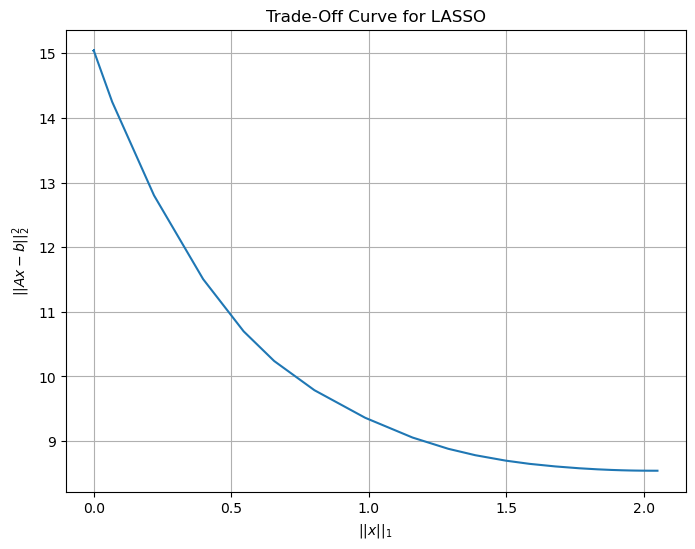

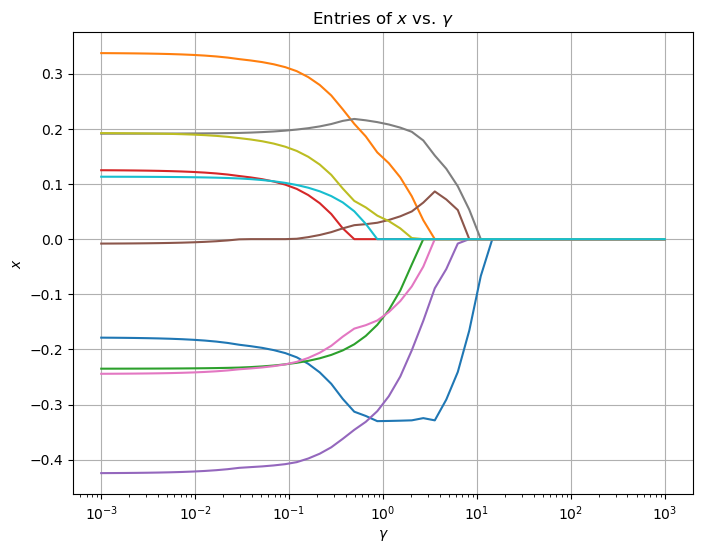

In [12]:
# construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
γ_vals = np.logspace(-3, 3)
sq_penalty = []
l1_penalty = []
x_values = []

for val in γ_vals:
    γ.value = val
    prob.solve()
    # Use expr.value to get the numerical value of an expression in the problem.
    sq_penalty.append(err.value)
    l1_penalty.append(reg.value)
    x_values.append(x.value)

# plot trade-off curve.
plt.figure(figsize=(8,6))
plt.plot(l1_penalty, sq_penalty)
plt.xlabel(r"$||x||_1$")
plt.ylabel(r"$||Ax-b||_2^2$")
plt.title("Trade-Off Curve for LASSO")
plt.grid()
plt.show()

# plot entries of x vs. gamma.
plt.figure(figsize=(8,6))
for i in range(m):
    plt.semilogx(γ_vals, [xi[i] for xi in x_values])
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$x$")
plt.title(r"Entries of $x$ vs. $\gamma$")
plt.grid()
plt.show()

Similar but different results with the sum_squares regularizer are shown below.

\begin{align*}
    \underset{x}{\min} \quad & \|Ax-b\|_2^2 + \gamma\|x\|_2^2
\end{align*}

In [13]:
# construct the problem
x = cp.Variable(m)
err = cp.sum_squares(A @ x - b)
reg = cp.sum_squares(x)
obj = cp.Minimize(err + γ * reg)
prob = cp.Problem(obj)

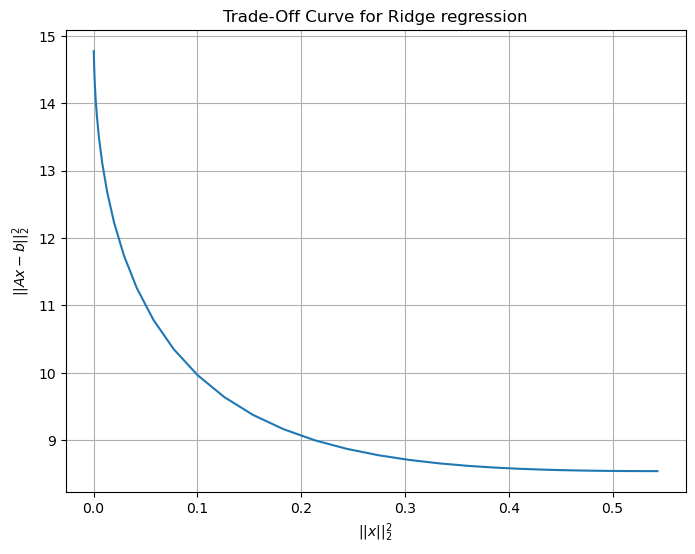

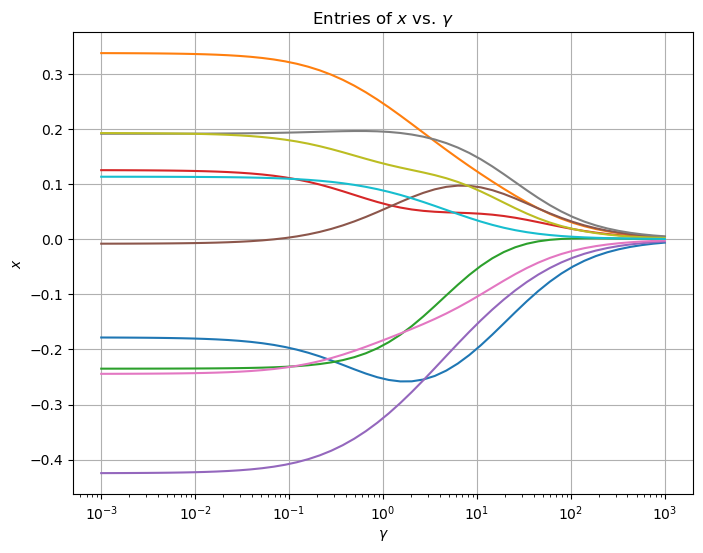

In [14]:
γ = cp.Parameter(nonneg=True)

# construct the problem
x = cp.Variable(m)
err = cp.sum_squares(A @ x - b)
reg = cp.sum_squares(x)

obj = cp.Minimize(err + γ * reg)
prob = cp.Problem(obj)

# construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
gamma_vals = np.logspace(-3, 3)
sq_penalty = []
l2_penalty = []
x_values = []

for val in γ_vals:
    γ.value = val
    prob.solve()
    # Use expr.value to get the numerical value of an expression in the problem.
    sq_penalty.append(err.value)
    l2_penalty.append(reg.value)
    x_values.append(x.value)

# plot trade-off curve.
plt.figure(figsize=(8,6))
plt.plot(l2_penalty, sq_penalty)
plt.xlabel(r"$||x||_2^2$")
plt.ylabel(r"$||Ax-b||_2^2$")
plt.title("Trade-Off Curve for Ridge regression")
plt.grid()
plt.show()

# plot entries of x vs. gamma.
plt.figure(figsize=(8,6))
for i in range(m):
    plt.semilogx(gamma_vals, [xi[i] for xi in x_values])
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$x$")
plt.title(r"Entries of $x$ vs. $\gamma$")
plt.grid()
plt.show()

### Non-negative Least Squares

Non-Negative Least Squares (NNLS) is an optimization technique. The  idea is to solve least squares problems with the additional constraint that the solution must be non-negative. This constraint is particularly useful in applications where negative values are not feasible or meaningful, such as in the analysis of physical quantities that cannot be negative.

The NNLS problem can be mathematically formulated as follows:

\begin{align*}
    \underset{\theta}{\min} \quad & \|X \theta + {\bf 1} b - y\|_2^2 \\
    \text{Subject to} \quad & \theta \geq 0
\end{align*}

#### Numerical example

In the following code we do a numerical example of Huber regression.

We generate $n=450$ measurements with incrasing number of feasures, randomly choose **non-negative** $\theta_\text{true}$, $b_\text{true}$, and $x_i \sim N(0,I)$, and set $y_i = \theta_\text{true}^Tx_i + b_\text{true} + \epsilon_i$, where $\epsilon_i \sim N(0,1)$ represents the measurement noise. Our goal is to recover $\theta_\text{true}$ and $b_\text{true}$ from the measurements $y$.

In [15]:
# init
np.random.seed(1)
n, d = 450, 10
theta_true = np.abs(np.random.randn(d)) # non-negative
b_true = np.random.randn()
# generate data
X = np.random.randn(n,d)
y = X @ theta_true + np.random.randn(n)
# non-negative regression problem
theta = cp.Variable(d)
b = cp.Variable()
cost = cp.norm(X @ theta + b - y)
prob = cp.Problem(cp.Minimize(cost), [theta >= 0, b >= 0])
prob.solve()
print(f"Optimal θ: {np.round(theta.value, 2)}")
print(f"Optimal b: {b.value:.2f}")

Optimal θ: [1.66 0.61 0.41 0.99 0.9  2.4  1.76 0.72 0.25 0.26]
Optimal b: 0.09


In [16]:
lsq_data = np.zeros(100)
nnls_data = np.zeros(100)
d_vals = np.linspace(10, 1000, 100).astype(int)

for i, d in tqdm(enumerate(d_vals)):
    # generate the sign changes
    np.random.seed(1)
    X = np.random.randn(n, d)
    theta_true = np.abs(np.random.randn(d))
    y = X @ theta_true + np.random.randn(n)

    # parameters
    theta = cp.Variable(d)
    b = cp.Variable()
    fit = cp.norm(theta - theta_true) / cp.norm(theta_true)

    # standard regression problem
    cost = cp.norm(X @ theta + b - y)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    lsq_data[i] = fit.value

    # NNLS regression
    cost = cp.sum(cp.huber(X @ theta + b - y, 1))
    prob = cp.Problem(cp.Minimize(cost), [theta >= 0, b >= 0])
    prob.solve()
    nnls_data[i] = fit.value

100it [01:35,  1.05it/s]


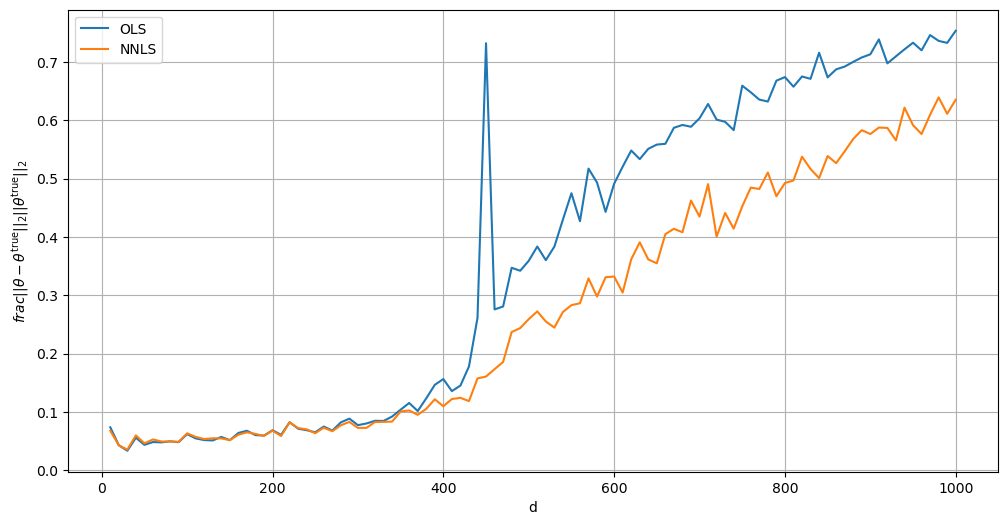

In [17]:
plt.figure(figsize=(12,6))
plt.plot(d_vals, lsq_data, label="OLS")
plt.plot(d_vals, nnls_data, label="NNLS")
plt.ylabel(r"$frac||{\theta - \theta^\mathrm{true} ||_2}{||\theta^\mathrm{true} ||_2}$")
plt.xlabel("d")
plt.grid()
plt.legend()
plt.show()

The NNLS problem thus seeks a more consistant parameter $\theta$.

### Huber regression

Given data $(x_i,y_i)\in {\bf R}^d \times {\bf R}$, $i=1,\ldots, n$, a standard regression fits a linear expression $\hat y_i = \theta ^T x_i + b$ and the error is $\epsilon = \theta ^T x_i + b - y_i$.

A more sophisticated variant is to replace the square function $\epsilon^2$ with the Huber function:

$$
h_\rho(\epsilon) = \begin{cases}
\epsilon^2 &\quad \text{if } |\epsilon| \le \rho \\
\rho\left(2|\epsilon|-\rho\right) &\quad \text{if }|\epsilon| \gt \rho
\end{cases}
$$

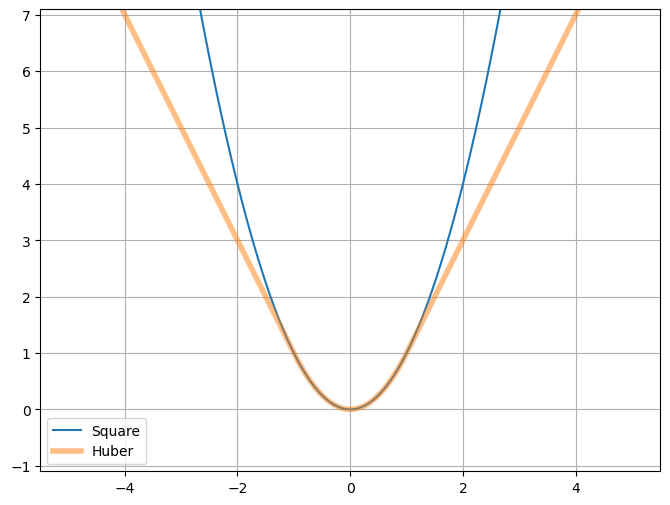

In [18]:
from scipy.special import huber

x_test = np.linspace(-5,5,500)
plt.figure(figsize=(8,6))
plt.plot(x_test,x_test**2, label="Square")
plt.plot(x_test, 2 * huber(1, x_test), linewidth=4, alpha=0.5, label="Huber")
plt.axis("equal")
plt.legend()
plt.ylim(0,6)
plt.grid()
plt.show()

Huber regression is the same as standard (least-squares) regression for small residuals, but allows (some) large residuals.

#### Numerical example

In the following code we do a numerical example of Huber regression.

We generate $n=450$ measurements with $d=300$ feasures, randomly choose $\theta_\text{true}$, $b_\text{true}$, and $x_i \sim N(0,I)$, and set $y_i = \theta_\text{true}^Tx_i + b_\text{true} + \epsilon_i$, where $\epsilon_i \sim N(0,1)$ represents the measurement noise. Then all kinds of nasty things come in; we **replace $y_i$ with $-y_i$ with probability $p$**. Our goal is to recover $\theta_\text{true}$ and $b_\text{true}$ from the measurements $y$.

We compare three approaches:

- Standard regression (least squares)
- Huber regression
- "Prescient" regression, where we know which measurements had their sign flipped.

Note that the "prescient" approach should be equivalent to "no-flip" case ($p=0$), since knowing the flipped measurements implies that we can re-flip those to recover the original unflipped signals. So the perfornance of the "prescient" approaches with different $p$'s should be identical for all $p$'s.

We generate $50$ problem instances, with $p$ varying from $0$ to $0.15$, and plot the relative error in reconstructing $\theta_\text{true}$ for the three approaches.

In [19]:
# init
np.random.seed(1)
n, d = 450, 300
theta_true = np.random.randn(d)
b_true = np.random.randn()
# generate data
X = np.random.randn(n,d)
y_orig = X @ theta_true + np.random.randn(n)
# flip sign
p = 0.08
sign = 2 * np.random.binomial(1, 1-p, size=(n,)) - 1
y_flip = sign * y_orig

In [20]:
lsq_data = np.zeros(100)
huber_data = np.zeros(100)
prescient_data = np.zeros(100)
p_vals = np.linspace(0, 0.15, 100)

for i, p in tqdm(enumerate(p_vals)):
    # generate the sign changes
    np.random.seed(1)
    sign = 2 * np.random.binomial(1, 1-p, size=(n,)) - 1
    y_flip = sign * (X @ theta_true + np.random.randn(n))

    # parameters
    theta = cp.Variable(d)
    b = cp.Variable()
    fit = cp.norm(theta - theta_true) / cp.norm(theta_true)

    # standard regression problem
    cost = cp.norm(X @ theta + b - y_flip)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    lsq_data[i] = fit.value

    # Huber regression
    cost = cp.sum(cp.huber(X @ theta + b - y_flip, 1))
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    huber_data[i] = fit.value

    # prescient regression problem
    cost = cp.norm(cp.multiply(sign, X @ theta + b) - y_flip)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    prescient_data[i] = fit.value

100it [01:30,  1.11it/s]


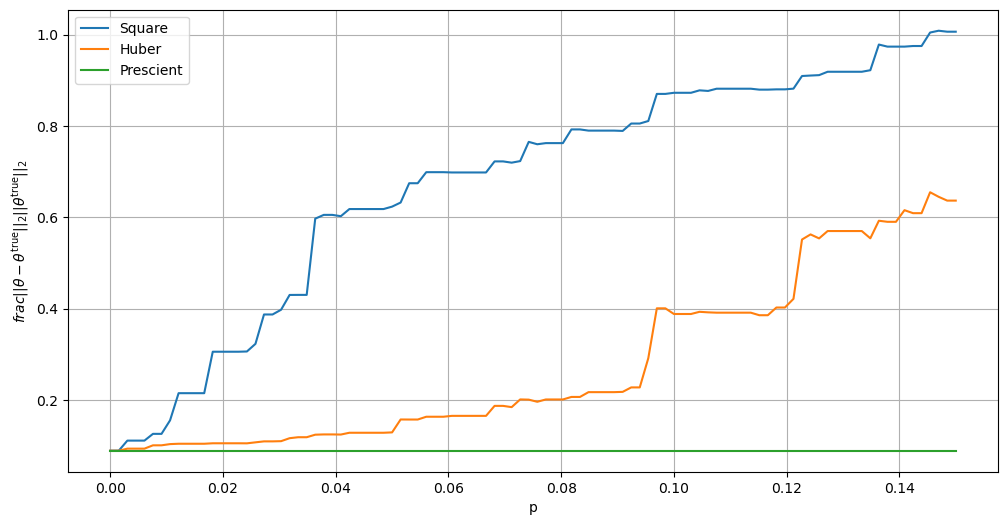

In [21]:
plt.figure(figsize=(12,6))
plt.plot(p_vals, lsq_data, label="Square")
plt.plot(p_vals, huber_data, label="Huber")
plt.plot(p_vals, prescient_data, label="Prescient")
plt.ylabel(r"$frac||{\theta - \theta^\mathrm{true} ||_2}{||\theta^\mathrm{true} ||_2}$")
plt.xlabel("p")
plt.grid()
plt.legend()
plt.show()

Huber regression almost matches prescient regression with small $p$. Standard regression, by contrast, fails.